# Googlemap apiを使って２地点の距離を取得し、距離データをグラフ化する

## Googlemap apiを使ってみる

In [13]:
import googlemaps
from datetime import datetime

In [2]:
gmaps = googlemaps.Client(key='取得したAPIキー')

now = datetime.now()
directions_result = gmaps.directions("千葉県船橋市習志野台７丁目５−１", 
                                     "北海道札幌市豊平区豊平５条１１丁目１−１",
                                     mode="walking",
                                     departure_time=now)

directions_result[0]['legs'][0]['distance']['text']

'1,032 km'

## Bリーグのデータを使って、試合会場間の距離を取得する

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 住所から２地点間の距離を取得する

In [14]:
gmaps = googlemaps.Client(key='取得したAPIキー')

def get_distance(ad_prev, ad_next):
    # 始点と終点が同じだとエラーになるので、始点＝終点なら距離０とする
    if ad_prev == ad_next:
        distance = '0 km'
    else:
        now = datetime.now()
        directions_result = gmaps.directions(ad_prev,
                                             ad_next,
                                             mode="walking",
                                             departure_time=now)
        distance = directions_result[0]['legs'][0]['distance']['text']
    
    return distance

### 指定したチームのデータを取得する

In [18]:
def get_tearm_data(df, team_name):
    df_sec = df.query('team_name == @team_name').copy()

    # 日程順にソート
    df_sec.loc[0:, 'date_DT'] = pd.to_datetime(df_sec.loc[0:, 'date'], format='%Y/%m/%d')
    df_sec = df_sec.sort_values('date_DT').reset_index(drop=True)

    # キョリを算出
    df_sec['distance_s'] = '0 Km'
    df_sec['distance'] = 0
    df_sec['accum'] = 0
    for index, row in df_sec.iterrows():
        if index > 0 :
            # 距離を取得
            distance = get_distance(df_sec.loc[index-1, 'address'] , df_sec.loc[index, 'address'])
            df_sec.loc[index, 'distance_s'] = distance
            # google map apiから「9,999 km」と返ってくるので、文字列から数値に変換する
            df_sec.loc[index, 'distance'] = float(distance.replace(' km','').replace(',',''))
            df_sec.loc[index, 'accum'] = df_sec.loc[index-1, 'accum'] + df_sec.loc[index, 'distance']
    
    return df_sec

### チーム名定義

In [19]:
team_name = [
    '千葉ジェッツ',
    '秋田ノーザンハピネッツ',
    '三遠ネオフェニックス',
    '滋賀レイクスターズ',
    'レバンガ北海道',
    'アルバルク東京',
    '名古屋ダイヤモンドドルフィンズ',
    '富山グラウジーズ',
    'ライジングゼファー福岡',
    '新潟アルビレックスBB',
    '栃木ブレックス',
    '川崎ブレイブサンダース',
    '京都ハンナリーズ',
    '大阪エヴェッサ',
    '琉球ゴールデンキングス',
    'シーホース三河',
    'サンロッカーズ渋谷',
    '横浜ビー・コルセアーズ']

### チームデータを取得し、csvに保存する

In [20]:
# 試合結果のデータを読み込む
df = pd.read_csv('B-stats.csv')

#df_data = pd.DataFrame()

# 距離を付与したチームデータを取得
for team in team_name:
    df_sec = get_tearm_data(df, team)
    if team == "千葉ジェッツ":
        df_data = df_sec
    else:
        df_data = pd.concat([df_data, df_sec])

# インデックスを振り直し
df_data.reset_index(drop=False)

# ファイルに出力
df_data.to_csv('B-stats_distance.csv')

## 散布図にしてみる

全チーム、各試合毎の、移動距離と総得点を散布図にプロットする

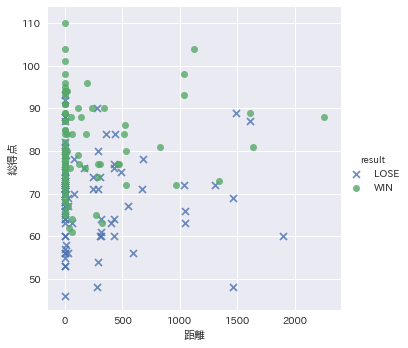

In [20]:
# 距離を付与したデータを読み込む
df_data = pd.read_csv('B-stats_distance.csv')


# 散布図
## 得点の型をint型へ
df_data['score_int'] = df_data['score'].astype(np.int64)
# フォントを指定
sns.set(font='IPAexGothic')

sns.lmplot(x="distance", y="score_int", size=5, hue="result", scatter=True, fit_reg=False, data=df_data, markers=["x", "o"])
plt.xlabel('距離')
plt.ylabel('総得点')
plt.show()

## 棒グラフで見てみる

各チーム別の移動距離を棒グラフで見てみる

In [2]:
# 距離を付与したデータを読み込む
df_data = pd.read_csv('B-stats_distance.csv')

# チーム別の総移動距離を求める
df_sec = df_data.groupby('abbr_team_name').sum()

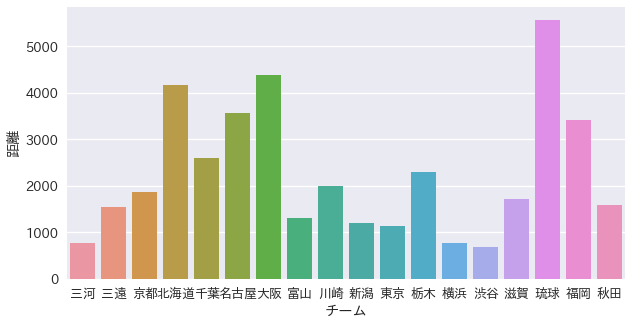

In [11]:
# 棒グラフ
plt.figure(figsize=(10, 5))
# フォントを指定
sns.set(font='IPAexGothic')

# 文字を少し大きく（"paper"<"notebook"<"talk"<"poster")
sns.set_context("talk")
sns.barplot(x=df_sec.index, y='distance', data=df_sec)
plt.xlabel('チーム')
plt.ylabel('距離')
plt.show()
